### Importing the  OASIS 2 Dataset: Longitudinal Demographics

In [1]:
import pandas as pd

data = pd.read_csv("oasis_longitudinal_demographics.csv")

data[:10]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


### Data cleaning
We check if there are any missing values in the dataset:

In [23]:
data.nWBV.median()

0.729

In [13]:
data.SES.mean()

2.4604519774011298

In [22]:
data.MMSE.median()

29.0

In [16]:
data.eTIV.min(), data.eTIV.max(), data.eTIV.mean()

(1106, 2004, 1488.1286863270777)

In [20]:
data.ASF.min(), data.ASF.max(), data.ASF.mean(), data.ASF.median()

(0.876, 1.587, 1.1954611260053618, 1.194)

In [2]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

We create the prep_data function, that drops unneeded columns:
- 'MR Delay', 'Group' and 'Visit' (this information does not apply to the analysis)
- 'Hand' (all patients are right handed)
- 'Subject ID', 'MRI ID' (they are just identification strings)

It splits the dataset into X and y. The target column 'CDR' is transformed into a binary class, giving the value of 0 to Non Demented and 1 to Demented (some level).

In [3]:
def prep_data(data):
    X=data.drop(columns=['CDR', 'MR Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit', 'Hand'])
    y=data['CDR'].apply(lambda x: 1 if x>0 else 0)
    X['SES'].fillna(value=X['SES'].median(), inplace=True)
    X['MMSE'].fillna(value=X['MMSE'].median(), inplace=True)
    return X, y

In [4]:
X, y= prep_data(data)

In [5]:
X.dtypes

M/F      object
Age       int64
EDUC      int64
SES     float64
MMSE    float64
eTIV      int64
nWBV    float64
ASF     float64
dtype: object

EDUC: Level of Education (6 to 23)

SES: Socioeconomic Status (1 to 5)

MMSE: Mini-Mental State Examination (4 to 30)

eTIV: Estimated total intracranial volume (mm3)

nWBV: Normalized whole brain volume

ASF: Atlas scaling factor

<AxesSubplot:>

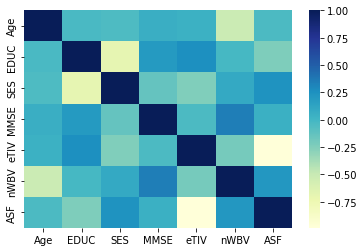

In [6]:
import seaborn as sns

corr = X.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

We can see that there is no important correlation in the actual features.

### Pipeline
We create a pipeline with all the transformations that will be applied to the data set, including imputing, scaling and encoding.

In [7]:
from sklearn.compose import ColumnTransformer

class CustomColumnTransformer(ColumnTransformer):
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns = self.get_feature_names_out())
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns = self.get_feature_names_out())

In [8]:
from sklearn import set_config; set_config(display='diagram')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

standard_features = ['Age']
robust_features = ['eTIV', 'MMSE']
minmax_features = ['EDUC', 'SES']
nothing_to_scale = ['nWBV','ASF']
binary_cat = ['M/F']

numerical_features = standard_features + robust_features + minmax_features + nothing_to_scale

numerical_transformer = CustomColumnTransformer([
    ('s_scaler', StandardScaler(), standard_features),
    ('m_scaler', MinMaxScaler(), minmax_features),
    ('r_scaler', RobustScaler(), robust_features)],
    remainder='passthrough')

#num_pipeline = Pipeline([('numerical_transformer', numerical_transformer)])

pre_pipe = CustomColumnTransformer([
    ('num_transformer', numerical_transformer, numerical_features),
    #('num_transformer', num_pipeline, numerical_features),
    ('encoder', OneHotEncoder(drop = "if_binary"), binary_cat)])
    
pre_pipe

CustomColumnTransformer(transformers=[('num_transformer',
                                       CustomColumnTransformer(remainder='passthrough',
                                                               transformers=[('s_scaler',
                                                                              StandardScaler(),
                                                                              ['Age']),
                                                                             ('m_scaler',
                                                                              MinMaxScaler(),
                                                                              ['EDUC',
                                                                               'SES']),
                                                                             ('r_scaler',
                                                                              RobustScaler(),
                                                                              ['eTIV',
                                                                               'MMSE'])]),
                                       ['Age', 'eTIV', 'MMSE', 'EDUC', 'SES',
                                        'nWBV', 'ASF']),
                                      ('encoder',
                                       OneHotEncoder(drop='if_binary'),
                                       ['M/F'])])

We now split the data into train and test set.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train = pre_pipe.fit_transform(X_train)
X_test = pre_pipe.transform(X_test)

In [11]:
X=pipeline.fit_transform()

NameError: name 'pipeline' is not defined

In [ ]:
X_train

In [ ]:
#SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)
#X_train=pd.DataFrame(preproc.fit_transform(X_train), columns = preproc.get_feature_names_out())
#X_test=pd.DataFrame(preproc.transform(X_test), columns = preproc.get_feature_names_out())

\
Renaming the column labels that were modified while applying the pipeline.

In [ ]:
# X_train = X_train.rename(columns={"s_scaler__Age": "Age",
#                               "m_scaler__EDUC": "Educ",
#                               "r_scaler__eTIV": "eTIV",
#                               "imp_scaler__MMSE": "MMSE",
#                               "encoder__M/F_M": "M/F",
#                               "imputer__SES": "SES",
#                               "remainder__nWBV": "nWBV",
#                               "remainder__ASF": "ASF"})
# X_test = X_test.rename(columns={"s_scaler__Age": "Age",
#                               "m_scaler__EDUC": "Educ",
#                               "r_scaler__eTIV": "eTIV",
#                               "imp_scaler__MMSE": "MMSE",
#                               "encoder__M/F_M": "M/F",
#                               "imputer__SES": "SES",
#                               "remainder__nWBV": "nWBV",
#                               "remainder__ASF": "ASF"})

# X_train = X_train[["M/F", "Age", "Educ", "SES", "MMSE", "eTIV", "nWBV", "ASF"]]
# X_test = X_test[["M/F", "Age", "Educ", "SES", "MMSE", "eTIV", "nWBV", "ASF"]]

### Choosing the right estimator

We will look now for the right estimator to solve this machine learning problem. Since we have a dataset size between 50 and 100k samples, and target is categorical, we will start with the Linear Support Vector Classification (SVC) estimator.



We will do GridSearch to find the best parameters on each model, scoring on "recall". This because we want to identify all the positive samples, in this case, the patients with dementia.

#### SVC

##### Linear SVC 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

model_svc_linear = LinearSVC(max_iter=100000)

parameters = {'C': [0.1, 1, 5, 50, 100, 500]}

gridsearch1 = GridSearchCV(model_svc_linear,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch1.fit(X_train, y_train)

In [ ]:
gridsearch1.best_params_

In [ ]:
gridsearch1.best_score_

In [ ]:
model_lsvc_best = LinearSVC(C= 100, max_iter=10000)
model_lsvc_best.fit(X_train, y_train)

Now we will predict the target:

In [ ]:
y_pred1 = model_lsvc_best.predict(X_test)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred1), recall_score(y_test, y_pred1), precision_score(y_test, y_pred1)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred1)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_svc_lin = confusion_matrix(y_test, y_pred1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_lin,
                             display_labels=["Nondemented","Demented"])
disp.plot(cmap = 'viridis')
plt.grid(visible = False)
plt.show()

##### SVC: Poly

In [ ]:
from sklearn.svm import SVC

model_svc_poly = SVC(kernel="poly")

parameters = {'C': [1, 10, 100, 1000, 10000, 100000],
              'gamma': [0.01, 0.1, 0.2, 0.5, 0.75, 1]}

gridsearch2 = GridSearchCV(model_svc_poly,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch2.fit(X_train, y_train)

In [ ]:
gridsearch2.best_params_

In [ ]:
gridsearch2.best_score_

In [ ]:
model_svc_poly_best = SVC(kernel="poly", C= 10, gamma=1)
model_svc_poly_best.fit(X_train, y_train)

In [ ]:
y_pred2 = model_svc_poly_best.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred2), recall_score(y_test, y_pred2), precision_score(y_test, y_pred2)

##### SVC: Rbf

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model_svc_rbf = SVC(kernel= 'rbf', max_iter=100000)

parameters = {'C': [1, 10, 50, 100, 500, 1000],
              'gamma': [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1]}

gridsearch3 = GridSearchCV(model_svc_rbf,
                          parameters,
                          n_jobs=-1,
                          cv=10,
                          scoring="recall")

gridsearch3.fit(X_train, y_train)

In [ ]:
gridsearch3.best_params_

In [ ]:
gridsearch3.best_score_

In [ ]:
model_svc_rbf_best = SVC(kernel="rbf", C= 10, gamma=0.75)
model_svc_rbf_best.fit(X_train, y_train)

In [ ]:
y_pred3 = model_svc_rbf_best.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred3), recall_score(y_test, y_pred3), precision_score(y_test, y_pred3)

#### KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

parameters = {'n_neighbors': range(2,30)}

gridsearch4 = GridSearchCV(knc,
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch4.fit(X_train, y_train)

In [ ]:
gridsearch4.best_params_

In [ ]:
gridsearch4.best_score_

In [ ]:
model_knc_best = KNeighborsClassifier(n_neighbors= 5)
model_knc_best.fit(X_train, y_train)

In [ ]:
y_pred4 = model_knc_best.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred4), recall_score(y_test, y_pred4), precision_score(y_test, y_pred4)

#### Decision Tree

We will create now a Decision Tree, to break down the data through binary decisions.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,10),
              'min_samples_leaf': range(1,10),
              'min_samples_split': range(2,10)}
gridsearch5 = GridSearchCV(DecisionTreeClassifier(),
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch5.fit(X_train, y_train)

In [ ]:
gridsearch5.best_params_

In [ ]:
gridsearch5.best_score_

In [ ]:
tree_clf = DecisionTreeClassifier(criterion= 'entropy', max_depth=8, min_samples_leaf= 4, min_samples_split= 5)
tree_clf.fit(X_train, y_train)

In [ ]:
import graphviz

from sklearn.tree import export_graphviz
export_graphviz(tree_clf, out_file="dt.dot", 
                feature_names=X_train.columns,
                class_names=['nondemented','demented'], 
                rounded=True, filled=True)

with open("dt.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

In [ ]:
y_pred5 = tree_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred5), recall_score(y_test, y_pred5), precision_score(y_test, y_pred5)

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()

parameters = {'n_estimators': [100, 200, 300],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [6,7,8,9,10],
              'criterion' :['gini', 'entropy']}

gridsearch6 = GridSearchCV(rfc, parameters, cv= 5, n_jobs=-1, scoring="recall")
gridsearch6.fit(X_train, y_train)

In [ ]:
gridsearch6.best_params_

In [ ]:
gridsearch6.best_score_

In [ ]:
rfc_best = RandomForestClassifier(n_estimators= 100, max_features= 'auto', max_depth= 8, criterion= 'gini')
rfc_best.fit(X_train, y_train)

In [ ]:
y_pred6 = rfc_best.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred6), recall_score(y_test, y_pred6), precision_score(y_test, y_pred6)

#### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 30, 50, 70, 80, 90, 100, 500],
              'learning_rate':[0.01, 0.5, 0.7, 0.8, 0.9, 0.95, 1]}
              #'learning_rate':[0.001, 0.01, 0.1, 0.5, 0.8, 0.9, 0.99, 1]}

gridsearch7 = GridSearchCV(AdaBoostClassifier(), parameters, cv= 5, n_jobs=-1, scoring="recall")
gridsearch7.fit(X_train, y_train)

In [ ]:
gridsearch7.best_params_

In [ ]:
gridsearch7.best_score_

In [ ]:
ada_best = AdaBoostClassifier(n_estimators= 80, learning_rate=0.9)
ada_best.fit(X_train, y_train)

In [ ]:
y_pred7 = ada_best.predict(X_test)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred7), recall_score(y_test, y_pred7), precision_score(y_test, y_pred7)

We have that the best estimator is the Random Forest Classifier. So we will add this estimator to the pipeline.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

pipe = Pipeline([
        ("preprocessor", pre_pipe),
        ("classifier", RandomForestClassifier(n_estimators= 100, max_features= 'auto', max_depth= 8, criterion= 'gini'))])
pipe

In [ ]:
pipe.fit(X_train, y_train)
#pipe.score(X_test,y_test)

In [ ]:
pipe.predict(X)

We are going to evaluate now our model in the OASIS1 transformed dataset and viceversa.

In [ ]:
frames=[X_piped, y]
oasis2 = pd.concat(frames, axis =1)
oasis2.to_csv(r'~/code/mkvph0ch/memobrain/notebooks/oasis2.csv', index_label=False)

In [ ]:
oasis1 = pd.read_csv("~/code/mkvph0ch/memobrain/raw_data/OASIS1/preprocessed_oasis1.csv")
oasis1

In [ ]:
X1=oasis1.drop(columns=['CDR'])
y1=oasis1['CDR']

In [ ]:
best_model = RandomForestClassifier(n_estimators= 100, max_features= 'auto', max_depth= 8, criterion= 'gini')
best_model.fit(X_train, y_train)

In [ ]:
y_pred_oasis1 = best_model.predict(X1)

In [ ]:
accuracy_score(y1, y_pred_oasis1), recall_score(y1, y_pred_oasis1), precision_score(y1, y_pred_oasis1)